In [ ]:
import pandas as pd
full_data = pd.read_csv('weatherAUS.csv')
full_data.head()

,Date,Location,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustDir,WindGustSpeed,WindDir9am,...,Humidity9am,Humidity3pm,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm,RainToday,RainTomorrow
0,2008-12-01,Albury,13.4,22.9,0.6,NaN,NaN,W,44.0,W,...,71.0,22.0,1007.7,1007.1,8.0,NaN,16.9,21.8,No,No
1,2008-12-02,Albury,7.4,25.1,0.0,NaN,NaN,WNW,44.0,NNW,...,44.0,25.0,1010.6,1007.8,NaN,NaN,17.2,24.3,No,No
2,2008-12-03,Albury,12.9,25.7,0.0,NaN,NaN,WSW,46.0,W,...,38.0,30.0,1007.6,1008.7,NaN,2.0,21.0,23.2,No,No
3,2008-12-04,Albury,9.2,28.0,0.0,NaN,NaN,NE,24.0,SE,...,45.0,16.0,1017.6,1012.8,NaN,NaN,18.1,26.5,No,No
4,2008-12-05,Albury,17.5,32.3,1.0,NaN,NaN,W,41.0,ENE,...,82.0,33.0,1010.8,1006.0,7.0,8.0,17.8,29.7,No,No


In [ ]:
full_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 145460 entries, 0 to 145459
Data columns (total 23 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   Date           145460 non-null  object 
 1   Location       145460 non-null  object 
 2   MinTemp        143975 non-null  float64
 3   MaxTemp        144199 non-null  float64
 4   Rainfall       142199 non-null  float64
 5   Evaporation    82670 non-null   float64
 6   Sunshine       75625 non-null   float64
 7   WindGustDir    135134 non-null  object 
 8   WindGustSpeed  135197 non-null  float64
 9   WindDir9am     134894 non-null  object 
 10  WindDir3pm     141232 non-null  object 
 11  WindSpeed9am   143693 non-null  float64
 12  WindSpeed3pm   142398 non-null  float64
 13  Humidity9am    142806 non-null  float64
 14  Humidity3pm    140953 non-null  float64
 15  Pressure9am    130395 non-null  float64
 16  Pressure3pm    130432 non-null  float64
 17  Cloud9am       89572 non-null

In [ ]:
full_data['RainTomorrow'].unique()

array(['No', 'Yes', nan], dtype=object)

In [ ]:
full_data['RainToday'].replace({'No': 0, 'Yes': 1},inplace = True)
full_data['RainTomorrow'].replace({'No': 0, 'Yes': 1},inplace = True)

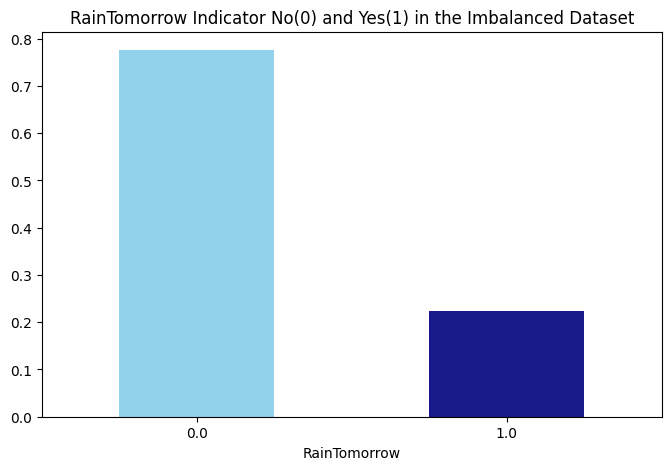

In [ ]:
import matplotlib.pyplot as plt
fig = plt.figure(figsize = (8,5))
full_data.RainTomorrow.value_counts(normalize = True).plot(kind='bar', color= ['skyblue','navy'], alpha = 0.9, rot=0)
plt.title('RainTomorrow Indicator No(0) and Yes(1) in the Imbalanced Dataset')
plt.show()

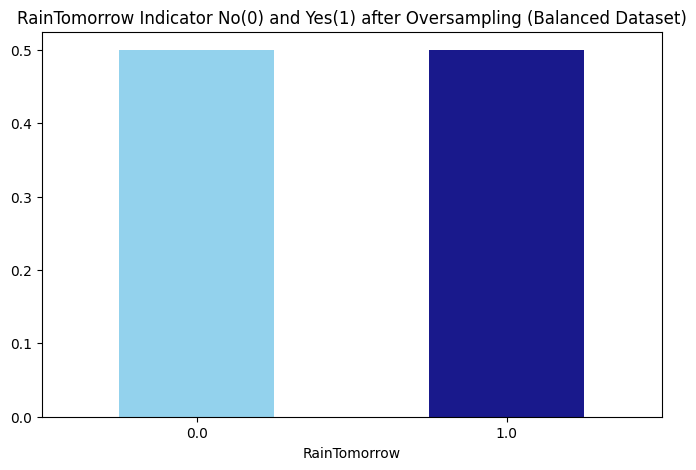

In [ ]:
## Handling Class Imbalance
from sklearn.utils import resample

no = full_data[full_data.RainTomorrow == 0]
yes = full_data[full_data.RainTomorrow == 1]
yes_oversampled = resample(yes, replace=True, n_samples=len(no), random_state=123)
oversampled = pd.concat([no, yes_oversampled])

fig = plt.figure(figsize = (8,5))
oversampled.RainTomorrow.value_counts(normalize = True).plot(kind='bar', color= ['skyblue','navy'], alpha = 0.9, rot=0)
plt.title('RainTomorrow Indicator No(0) and Yes(1) after Oversampling (Balanced Dataset)')
plt.show()

In [ ]:
oversampled.select_dtypes(include=['object']).columns

Index(['Date', 'Location', 'WindGustDir', 'WindDir9am', 'WindDir3pm'], dtype='object')

In [ ]:
# Multiple Imputation by Chained Equations
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
oversampled = oversampled.drop(oversampled.select_dtypes(include=['object']).columns, axis=1)
MiceImputed = oversampled.copy(deep=True)
mice_imputer = IterativeImputer()
MiceImputed.iloc[:, :] = mice_imputer.fit_transform(oversampled)

/usr/local/lib/python3.10/dist-packages/sklearn/impute/_iterative.py:785: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(


In [ ]:
# Detecting outliers with IQR
Q1 = MiceImputed.quantile(0.25)
Q3 = MiceImputed.quantile(0.75)
IQR = Q3 - Q1
print(IQR)

MinTemp           9.300000
MaxTemp          10.200000
Rainfall          2.400000
Evaporation       4.013212
Sunshine          5.948410
WindGustSpeed    19.000000
WindSpeed9am     13.000000
WindSpeed3pm     11.000000
Humidity9am      26.000000
Humidity3pm      30.000000
Pressure9am       8.800000
Pressure3pm       8.830981
Cloud9am          4.000000
Cloud3pm          3.686619
Temp9am           9.300000
Temp3pm           9.800000
RainToday         1.000000
RainTomorrow      1.000000
dtype: float64


In [ ]:
# Removing outliers from dataset
MiceImputed = MiceImputed[~((MiceImputed < (Q1 - 1.5 * IQR)) |(MiceImputed > (Q3 + 1.5 * IQR))).any(axis=1)]
MiceImputed.shape

(170483, 18)

In [ ]:
features = MiceImputed[['MinTemp', 'MaxTemp', 'Humidity9am', 'Humidity3pm',
                        'Pressure9am', 'Pressure3pm', 'Temp9am', 'Temp3pm',
                        'RainToday']]
target = MiceImputed['RainTomorrow']

# Split into test and train
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.25, random_state=12345)

In [ ]:
features.info()

<class 'pandas.core.frame.DataFrame'>
Index: 170483 entries, 0 to 27220
Data columns (total 9 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   MinTemp      170483 non-null  float64
 1   MaxTemp      170483 non-null  float64
 2   Humidity9am  170483 non-null  float64
 3   Humidity3pm  170483 non-null  float64
 4   Pressure9am  170483 non-null  float64
 5   Pressure3pm  170483 non-null  float64
 6   Temp9am      170483 non-null  float64
 7   Temp3pm      170483 non-null  float64
 8   RainToday    170483 non-null  float64
dtypes: float64(9)
memory usage: 13.0 MB


In [ ]:
MiceImputed['RainTomorrow'].unique()

array([0., 1.])

In [ ]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 127862 entries, 133358 to 118292
Data columns (total 9 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   MinTemp      127862 non-null  float64
 1   MaxTemp      127862 non-null  float64
 2   Humidity9am  127862 non-null  float64
 3   Humidity3pm  127862 non-null  float64
 4   Pressure9am  127862 non-null  float64
 5   Pressure3pm  127862 non-null  float64
 6   Temp9am      127862 non-null  float64
 7   Temp3pm      127862 non-null  float64
 8   RainToday    127862 non-null  float64
dtypes: float64(9)
memory usage: 9.8 MB


In [ ]:
y_train.unique()

array([0., 1.])

In [ ]:
X_test.info()

<class 'pandas.core.frame.DataFrame'>
Index: 42621 entries, 97913 to 129739
Data columns (total 9 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   MinTemp      42621 non-null  float64
 1   MaxTemp      42621 non-null  float64
 2   Humidity9am  42621 non-null  float64
 3   Humidity3pm  42621 non-null  float64
 4   Pressure9am  42621 non-null  float64
 5   Pressure3pm  42621 non-null  float64
 6   Temp9am      42621 non-null  float64
 7   Temp3pm      42621 non-null  float64
 8   RainToday    42621 non-null  float64
dtypes: float64(9)
memory usage: 3.3 MB


In [ ]:
# Normalize Features
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.fit_transform(X_test)

In [ ]:
def plot_roc_cur(fper, tper):
    plt.plot(fper, tper, color='orange', label='ROC')
    plt.plot([0, 1], [0, 1], color='darkblue', linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend()
    plt.show()

In [ ]:
import time
from sklearn.metrics import accuracy_score, roc_auc_score, cohen_kappa_score, roc_curve, classification_report
def run_model(model, X_train, y_train, X_test, y_test, verbose=True):
    t0=time.time()
    if verbose == False:
        model.fit(X_train,y_train, verbose=0)
    else:
        model.fit(X_train,y_train)
    y_pred = model.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    roc_auc = roc_auc_score(y_test, y_pred)
    coh_kap = cohen_kappa_score(y_test, y_pred)
    time_taken = time.time()-t0
    print("Accuracy = {}".format(accuracy))
    print("ROC Area under Curve = {}".format(roc_auc))
    print("Cohen's Kappa = {}".format(coh_kap))
    print("Time taken = {}".format(time_taken))
    print(classification_report(y_test,y_pred,digits=5))

    probs = model.predict_proba(X_test)
    probs = probs[:, 1]
    fper, tper, thresholds = roc_curve(y_test, probs)
    plot_roc_cur(fper, tper)

    return model, accuracy, roc_auc, coh_kap, time_taken

Accuracy = 0.7354825086225101
ROC Area under Curve = 0.7228178672592946
Cohen's Kappa = 0.45354181167861096
Time taken = 301.35326051712036
              precision    recall  f1-score   support

         0.0    0.73448   0.82724   0.77811     23895
         1.0    0.73720   0.61839   0.67259     18726

    accuracy                        0.73548     42621
   macro avg    0.73584   0.72282   0.72535     42621
weighted avg    0.73568   0.73548   0.73175     42621



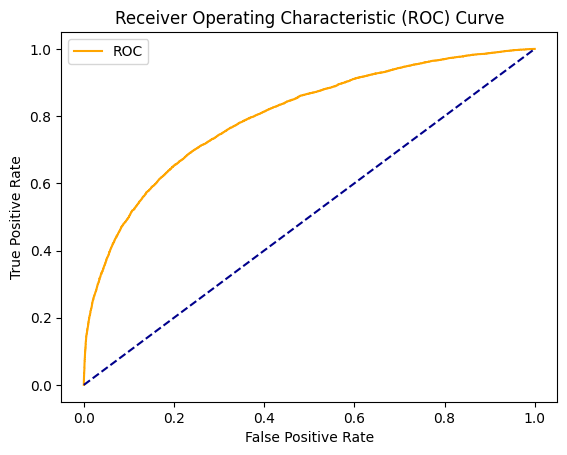

In [ ]:
from sklearn.neural_network import MLPClassifier

params_nn = {'hidden_layer_sizes': (30,30,30),
             'activation': 'logistic',
             'solver': 'lbfgs',
             'max_iter': 500}

model_nn = MLPClassifier(**params_nn)
model_nn, accuracy_nn, roc_auc_nn, coh_kap_nn, tt_nn = run_model(model_nn, X_train, y_train, X_test, y_test)

In [ ]:
from joblib import dump
dump(model_nn, 'rain_predict_model.joblib')

['rain_predict_model.joblib']

In [ ]:
arr=[[4.5,12.7,99,91,1021.4,1020.3,6.7,11.9,0]]
model_nn.predict(arr)

array([1.])

In [ ]:
while True: pass

KeyboardInterrupt: 